# Appendix 04 - Exploring Clustering Methods: *Deterministic and Stochastic approaches*

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from models.deterministic_radially_constrained_cluster import *  # Adjust import as per your package structure
from models.radially_constrained_cluster import *
from models.X_RCC import XRCC
from visualization.custom_plots import standard_format, day_of_year_to_date
import itertools

In [3]:
# -- PARAMETERS 

# Common parameters
n_seas = 2
min_len= 1
metric = 'euclidean'

# Deterministic model parameters
n_days = list(np.arange(0,365,3))

# Stochastic model parameters
iters = 300
learning_rate   = 1

starting_bp     = [50, 330]

lat = 28
lon = 80

In [4]:
dataset_t2m = xr.open_mfdataset(rf'../data/preprocessed/ERA5/2m_temperature/final.nc')['2t'].load().sel(lat=lat, lon=lon, method='nearest')
dataset_tp = xr.open_mfdataset(rf'../data/preprocessed/ERA5/total_precipitation/final.nc').tp.load().sel(lat=lat, lon=lon, method='nearest')
dataset_u100 = xr.open_mfdataset(rf'../data/preprocessed/ERA5/100m_u_wind/final.nc').u100.load().sel(lat=lat, lon=lon, method='nearest')
dataset_v100 = xr.open_mfdataset(rf'../data/preprocessed/ERA5/100m_v_wind/final.nc').v100.load().sel(lat=lat, lon=lon, method='nearest')

dataset_tp['time'] = dataset_t2m['time']
dataset_u100['time'] = dataset_t2m['time']
dataset_v100['time'] = dataset_t2m['time']

datasets = [dataset_tp, dataset_t2m, dataset_u100, dataset_v100]  # Add as many datasets as needed

/home/jgrassi/miniconda3/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.24.2
  warnings.warn(


In [5]:
datasets_tab = [dataset.to_dataframe() for dataset in datasets]

datasets_tab = [dataset.dropna() for dataset in datasets_tab]
datasets_tab = pd.concat(datasets_tab, axis=1)

datasets_tab = datasets_tab.drop(columns=['lon','lat','spatial_ref'])
# Remove hours from datetime
datasets_tab.index = pd.to_datetime(datasets_tab.index.astype(str))

In [6]:
# Reshape the table to keep the day of the year as the index and for the columns the values of the different variables at each year.
# The final shape will be 365 * n_years x n_variables. Remove the empy values
datasets_tab_res = datasets_tab.pivot_table(index=datasets_tab.index.dayofyear, columns=datasets_tab.index.year)
datasets_tab_res.columns = [f'{var}_{year}' for var, year in datasets_tab_res.columns]
datasets_tab_res

,2t_1969,2t_1970,2t_1971,2t_1972,2t_1973,2t_1974,2t_1975,2t_1976,2t_1977,2t_1978,...,v100_2009,v100_2010,v100_2011,v100_2012,v100_2013,v100_2014,v100_2015,v100_2016,v100_2017,v100_2018
time,,,,,,,,,,,,,,,,,,,,,
1,286.421112,287.862946,287.481293,287.459747,290.351746,286.143738,287.079132,288.391449,288.386719,286.296570,...,-0.757658,-0.762310,-1.397434,-0.609624,-0.994971,-1.025588,-0.947749,-1.146635,-0.393102,-0.767026
2,286.415466,287.895538,287.587555,287.335449,290.412262,286.484955,287.259827,288.268951,288.317932,286.136230,...,-0.799099,-0.709980,-1.438688,-0.674785,-1.034110,-0.940446,-0.930903,-1.177706,-0.598872,-0.704788
3,286.571136,287.930176,287.530792,287.332520,290.290741,286.818329,287.509399,288.256561,288.214172,286.041016,...,-0.904859,-0.679166,-1.406034,-0.738758,-1.128538,-0.723004,-0.821817,-1.199870,-0.620023,-0.691203
4,286.697418,287.911804,287.472015,287.312500,290.049774,287.054779,287.629913,288.192352,288.249664,286.006500,...,-0.993890,-0.675825,-1.342501,-0.776968,-1.154907,-0.716395,-0.734977,-1.125410,-0.677776,-0.738319
5,286.780823,288.003052,287.446503,287.329590,289.880676,287.349548,287.604462,288.157806,288.240295,285.982208,...,-1.108445,-0.593472,-1.308078,-0.876247,-1.150051,-0.546216,-0.668302,-0.977807,-0.666004,-0.714043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,287.596039,287.681366,288.548615,290.164917,285.394196,286.828674,288.554260,288.350250,287.289886,287.136353,...,-1.086702,-1.320573,-1.021151,-0.756301,-0.949801,-0.738872,-1.235355,-0.524321,-0.791924,-1.330765
363,287.640808,287.673279,288.414185,290.108307,285.541443,286.881409,288.607880,288.354218,286.943695,287.094238,...,-1.049502,-1.315273,-1.005877,-0.719653,-1.080182,-0.812677,-1.273662,-0.348308,-0.746334,-1.181522
364,287.726074,287.633972,288.124603,289.977692,285.652405,286.985321,288.581635,288.488220,286.662415,287.153717,...,-0.949331,-1.381602,-0.707459,-0.748219,-1.169332,-0.914205,-1.204041,-0.254778,-0.740771,-1.251708


In [7]:
dataset_tab_res_norm = (datasets_tab_res - datasets_tab_res.min(axis=0))/(datasets_tab_res.max(axis=0) - datasets_tab_res.min(axis=0))
#dataset_tab_res_norm = (datasets_tab_res - datasets_tab_res.mean(axis=0))/datasets_tab_res.std(axis=0)
dataset_tab_res_norm

,2t_1969,2t_1970,2t_1971,2t_1972,2t_1973,2t_1974,2t_1975,2t_1976,2t_1977,2t_1978,...,v100_2009,v100_2010,v100_2011,v100_2012,v100_2013,v100_2014,v100_2015,v100_2016,v100_2017,v100_2018
time,,,,,,,,,,,,,,,,,,,,,
1,0.010073,0.028890,0.068004,0.021609,0.242886,0.000000,0.000000,0.053080,0.092168,0.013608,...,0.464673,0.436834,0.314472,0.569587,0.395545,0.553384,0.300502,0.290038,0.557667,0.420728
2,0.009817,0.030427,0.074215,0.016129,0.245637,0.016151,0.008559,0.047076,0.088918,0.006667,...,0.454174,0.449481,0.305677,0.555343,0.386788,0.573253,0.304986,0.281873,0.500699,0.442589
3,0.016887,0.032060,0.070897,0.016000,0.240114,0.031931,0.020381,0.046468,0.084016,0.002546,...,0.427382,0.456927,0.312639,0.541359,0.365661,0.623996,0.334021,0.276048,0.494844,0.447361
4,0.022623,0.031194,0.067461,0.015118,0.229162,0.043122,0.026089,0.043321,0.085693,0.001052,...,0.404827,0.457735,0.326183,0.533006,0.359761,0.625539,0.357135,0.295616,0.478855,0.430811
5,0.026411,0.035496,0.065970,0.015871,0.221477,0.057075,0.024883,0.041628,0.085251,0.000000,...,0.375807,0.477638,0.333522,0.511304,0.360848,0.665253,0.374881,0.334405,0.482114,0.439338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,0.063439,0.020329,0.130394,0.140864,0.017569,0.032420,0.069873,0.051061,0.040349,0.049959,...,0.381315,0.301914,0.394693,0.537524,0.405651,0.620293,0.223951,0.453580,0.447253,0.222710
363,0.065472,0.019948,0.122536,0.138368,0.024261,0.034916,0.072413,0.051255,0.023993,0.048136,...,0.390739,0.303196,0.397949,0.545535,0.376480,0.603070,0.213755,0.499835,0.459874,0.275133
364,0.069345,0.018095,0.105608,0.132610,0.029305,0.039835,0.071169,0.057823,0.010704,0.050711,...,0.416116,0.287165,0.461569,0.539290,0.356534,0.579376,0.232286,0.524414,0.461415,0.250480


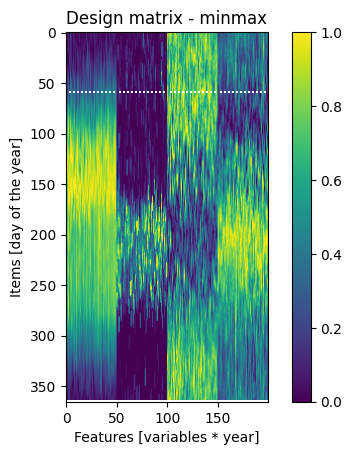

In [8]:
plt.figure()
plt.imshow(dataset_tab_res_norm.values)
plt.xlabel('Features [variables * year]')
plt.ylabel('Items [day of the year]')
plt.title('Design matrix - minmax')
plt.colorbar()

In [9]:
arrays = []

for grid_points_var in datasets:
    grid_points_var = np.asarray(grid_points_var)
    grid_points_var = np.reshape(grid_points_var, (365, int(grid_points_var.size/365)), order='F')
    
    if np.isnan(grid_points_var).any():
        array_tot = (np.full(n_seas, np.nan), np.full(iters, np.nan), np.full(iters, np.nan))
    
    arrays.append(grid_points_var)

combined_mask = ~np.any([np.all(np.isnan(arr), axis=0) for arr in arrays], axis=0)

normalized_arrays = []
for arr in arrays:
    array_tot = arr[:, combined_mask]
    array_tot = (array_tot - array_tot.min(axis=0)) / (array_tot.max(axis=0) - array_tot.min(axis=0))
    #array_tot = (array_tot - array_tot.mean(axis=0)) / array_tot.std(axis=0)
    normalized_arrays.append(array_tot)

    array_tot = np.concatenate(normalized_arrays, axis=1)

In [10]:
from sklearn.metrics import silhouette_score

best, err, bp_list = single_fit_optimized(array_tot, n_seas, n_days, metric=metric)

7381it [00:08, 846.99it/s]


43424719800.0

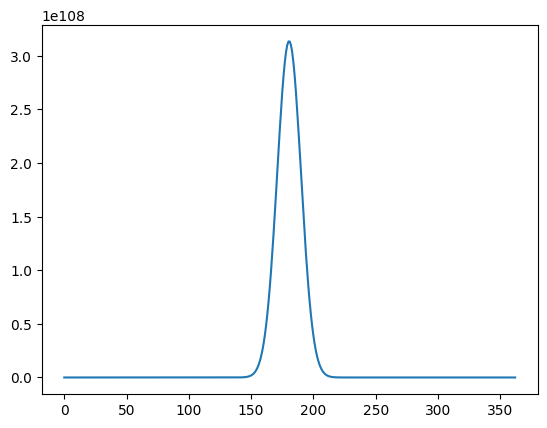

In [44]:
# Compute binomial coefficient
import scipy.special

# Plot the binomial of 365,n with n in x axis
plt.figure()
plt.plot([scipy.special.binom(365, n) for n in range(2,365)])

scipy.special.binom(180, 6)

In [11]:
# # Costruisci variabili indipendenti dinamicamente dalle combinazioni
# variables = np.array(list(combinations(n_days, n_seas))).T  # Variabili indipendenti in forma (n_dimensions, n_combinations)

# # Definiamo X_grid come la meshgrid multidimensionale di ciascuna variabile
# unique_vars = [np.unique(var) for var in variables]
# grids = np.meshgrid(*unique_vars, indexing='ij')  # Griglia multidimensionale per tutte le variabili

# # Creare Z con una dimensione extra per le dimensioni di err
# Z = np.empty(grids[0].shape + (n_seas,))  # Z ha le dimensioni della griglia e una dimensione extra per err

# # Riempimento di Z con valori medi per ciascuna combinazione unica delle variabili
# for index in np.ndindex(grids[0].shape):  # Itera su tutti gli indici della griglia
#     # Trova gli indici che corrispondono a ciascuna combinazione di variabili
#     indices = np.all([variables[i] == grids[i][index] for i in range(len(variables))], axis=0)
    
#     # Calcola la media se esistono valori corrispondenti
#     if np.any(indices):
#         Z[index] = np.mean(err[indices], axis=0)
#     else:
#         Z[index] = np.nan  # Riempire con NaN se nessun valore corrisponde

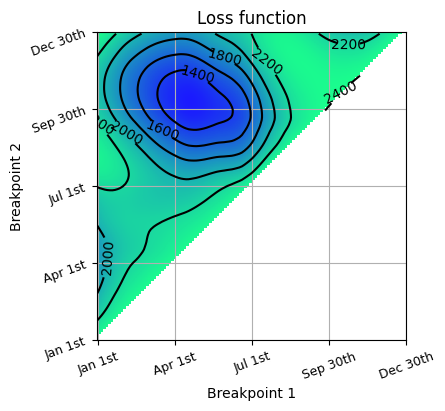

In [12]:
x = np.array(list(combinations(n_days, n_seas))).squeeze()[:,0]
y = np.array(list(combinations(n_days, n_seas))).squeeze()[:,1]


# # Creare una meshgrid di x e y
X, Y = np.meshgrid(np.unique(x), np.unique(y))

# Creare un array per Z con le dimensioni di X e Y
Z = np.empty(X.shape)

# Riempire Z con valori medi di z_all raggruppati
for i in range(len(np.unique(x))):
    for j in range(len(np.unique(y))):
        # Trovare i punti che corrispondono a questo (x, y)
        indices = (x == X[j, i]) & (y == Y[j, i])  # Aggiorna per la tua logica
        Z[j, i] = np.mean([err[k] for k in range(len(err)) if indices[k]]) if np.any(indices) else np.nan  # Media dei valori corrispondenti

        

# Creare il grafico a contorni riempiti
plt.figure(figsize=(8, 4))
contour= plt.contour(X, Y, Z, levels=6, colors='black')
plt.imshow(Z, extent=(X.min(), X.max(), Y.min(), Y.max()), origin='lower', cmap='winter', alpha=0.9)


ax = plt.gca()
ax.clabel(contour, inline=True, fontsize=10)

#plt.colorbar(contour)
plt.title('Loss function')
plt.xlabel('Breakpoint 1')
plt.ylabel('Breakpoint 2')
plt.grid()

# .
ax = plt.gca()
ax.set_xticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)
ax.set_yticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)

Text(0, 0.5, 'WCSS')

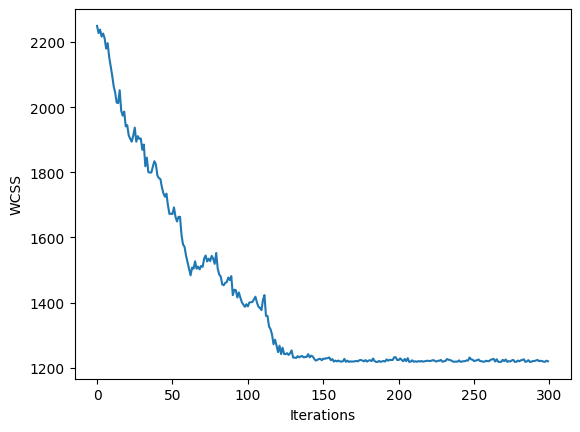

In [13]:
clustering_params = {
        'n_iter': iters,
        'n_seas': n_seas,
        'learning_rate': 3,
        'scheduling_factor':1,
        'min_len': 1,
        'mode': 'single',
        'starting_bp': list(np.sort(np.random.randint(0, 365, n_seas))),
        'metric': metric,
    }

model = Radially_Constrained_Cluster(array_tot, **clustering_params)

model.fit()

plt.plot(model.error_history)
plt.xlabel('Iterations')
plt.ylabel('WCSS')

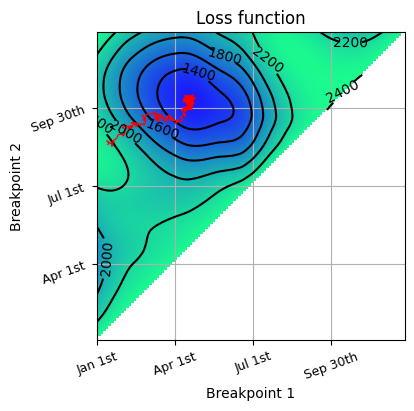

In [14]:
x = np.array(list(combinations(n_days, 2))).squeeze()[:,0]
y = np.array(list(combinations(n_days, 2))).squeeze()[:,1]

# Creare una meshgrid di x e y
X, Y = np.meshgrid(np.unique(x), np.unique(y))

# Creare un array per Z con le dimensioni di X e Y
Z = np.empty(X.shape)

# Riempire Z con valori medi di z_all raggruppati
for i in range(len(np.unique(x))):
    for j in range(len(np.unique(y))):
        # Trovare i punti che corrispondono a questo (x, y)
        indices = (x == X[j, i]) & (y == Y[j, i])  # Aggiorna per la tua logica
        Z[j, i] = np.mean([err[k] for k in range(len(err)) if indices[k]]) if np.any(indices) else np.nan  # Media dei valori corrispondenti

# Creare il grafico a contorni riempiti
plt.figure(figsize=(8, 4))
contour= plt.contour(X, Y, Z, levels=6, colors='black')
plt.imshow(Z, extent=(X.min(), X.max(), Y.min(), Y.max()), origin='lower', cmap='winter', alpha=0.9)


ax = plt.gca()
ax.clabel(contour, inline=True, fontsize=10)

#plt.colorbar(contour)
plt.title('Loss function')
plt.xlabel('Breakpoint 1')
plt.ylabel('Breakpoint 2')
plt.grid()

# .
ax = plt.gca()
ax.set_xticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)
ax.set_yticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)

plt.plot(model.breakpoint_history[:,0],model.breakpoint_history[:,1], '-o', color='red', lw=0.8, markersize=0.1)

In [15]:
model.breakpoints

array([107, 282], dtype=int32)

In [16]:
# Import the reference dates

literature_results_path  = f'../data/preprocessed/external/monsoon_dates.nc'
literature_results = xr.open_dataset(literature_results_path).drop('spatial_ref')

/tmp/ipykernel_1706181/1448965862.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  literature_results = xr.open_dataset(literature_results_path).drop('spatial_ref')


In [17]:
literature_results_point = literature_results.sel(lat=lat, lon=lon, method='nearest')
literature_results_point.date.values

array([175.03559031, 273.87781213])

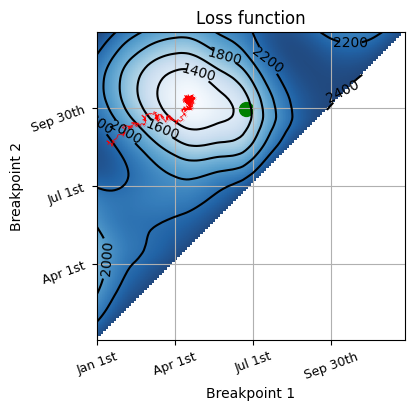

In [18]:
x = np.array(list(combinations(n_days, 2))).squeeze()[:,0]
y = np.array(list(combinations(n_days, 2))).squeeze()[:,1]

# Creare una meshgrid di x e y
X, Y = np.meshgrid(np.unique(x), np.unique(y))

# Creare un array per Z con le dimensioni di X e Y
Z = np.empty(X.shape)

# Riempire Z con valori medi di z_all raggruppati
for i in range(len(np.unique(x))):
    for j in range(len(np.unique(y))):
        # Trovare i punti che corrispondono a questo (x, y)
        indices = (x == X[j, i]) & (y == Y[j, i])  # Aggiorna per la tua logica
        Z[j, i] = np.mean([err[k] for k in range(len(err)) if indices[k]]) if np.any(indices) else np.nan  # Media dei valori corrispondenti

# Creare il grafico a contorni riempiti
plt.figure(figsize=(8, 4))
contour= plt.contour(X, Y, Z, levels=6, colors='black')
plt.imshow(Z, extent=(X.min(), X.max(), Y.min(), Y.max()), origin='lower', cmap='Blues', alpha=0.9)


ax = plt.gca()
ax.clabel(contour, inline=True, fontsize=10)

#plt.colorbar(contour)
plt.title('Loss function')
plt.xlabel('Breakpoint 1')
plt.ylabel('Breakpoint 2')
plt.grid()

# .
ax = plt.gca()
ax.set_xticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)
ax.set_yticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)

plt.plot(model.breakpoint_history[:,0],model.breakpoint_history[:,1], '-o', color='red', lw=0.5, markersize=0.1)
plt.scatter(literature_results_point.date.values[0], literature_results_point.date.values[1], marker='o', color='green', s=100)